In [1]:
from datasets import load_dataset
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize
from pathlib import Path
import csv
import nibabel as nib

In [2]:
ds = load_dataset("rajpurkarlab/3DReasonKnee")

In [3]:
for dirname, _, filenames in os.walk('home/dominika/Projekty_MGR/Knee-injury-scanner/datasets/kneeMRI'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
def load_pickle_image(file_path, target_size):
    with open(file_path, "rb") as f:
        img = pickle.load(f)
    return img

In [5]:
print("cwd:", os.getcwd())
img = load_pickle_image('/home/dominika/Projekty_MGR/Knee-injury-scanner/datasets/kneeMRI/vol08/919791-8.pck', (224, 224))

cwd: /home/dominika/Projekty_MGR/Knee-injury-scanner/src/model_training/training_helpers


Z-axis spacing (width) between slices set to: 10.0


/tmp/ipykernel_73982/709726739.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = cm.get_cmap('gray')


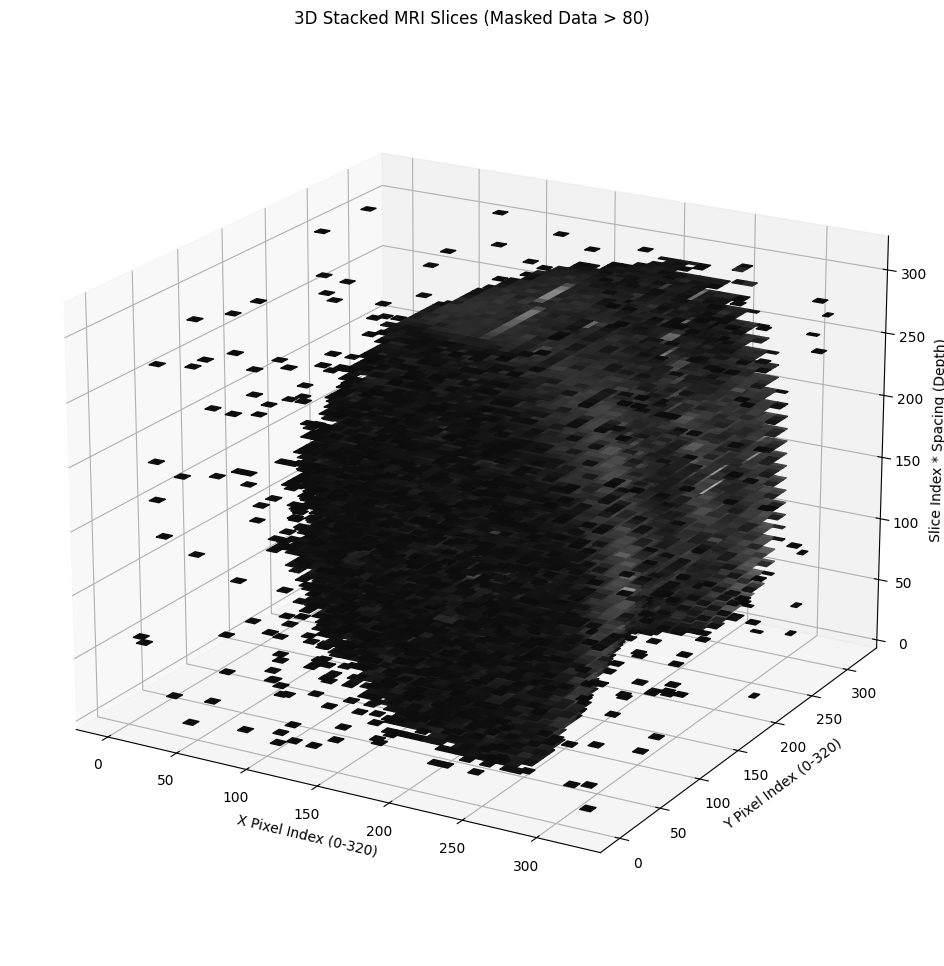

In [6]:
# --- 1. Data Simulation ---
mask = img > 120
mri_data = img.astype(np.float32) * mask.astype(np.float32)

Z_SPACING_FACTOR = 10.0
print(f"Z-axis spacing (width) between slices set to: {Z_SPACING_FACTOR}")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

S, H, W = mri_data.shape
X_coords = np.arange(W)
Y_coords = np.arange(H)
X_mesh, Y_mesh = np.meshgrid(X_coords, Y_coords)

# --- 2. Create a Custom Colormap for Transparency ---
base_cmap = cm.get_cmap('gray')
new_colors = base_cmap(np.arange(base_cmap.N))
new_colors[0, 3] = 0.0
transparent_cmap = ListedColormap(new_colors)
norm = Normalize(vmin=0, vmax=mri_data.max())

# --- 3. Plot Each Slice ---
for i in range(S):
    Z_plane = i * Z_SPACING_FACTOR * np.ones_like(X_mesh)
    slice_data = mri_data[i, :, :]
    rgba_colors = transparent_cmap(norm(slice_data))

    ax.plot_surface(
        X_mesh, Y_mesh, Z_plane,
        facecolors=rgba_colors,
        rcount=50, ccount=50,
        shade=False,
    )

ax.set_title(f'3D Stacked MRI Slices (Masked Data > 80)')
ax.set_xlabel('X Pixel Index (0-320)')
ax.set_ylabel('Y Pixel Index (0-320)')
ax.set_zlabel('Slice Index * Spacing (Depth)')

ax.set_zlim(0, S * Z_SPACING_FACTOR)
ax.view_init(elev=20, azim=-60)

plt.show()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

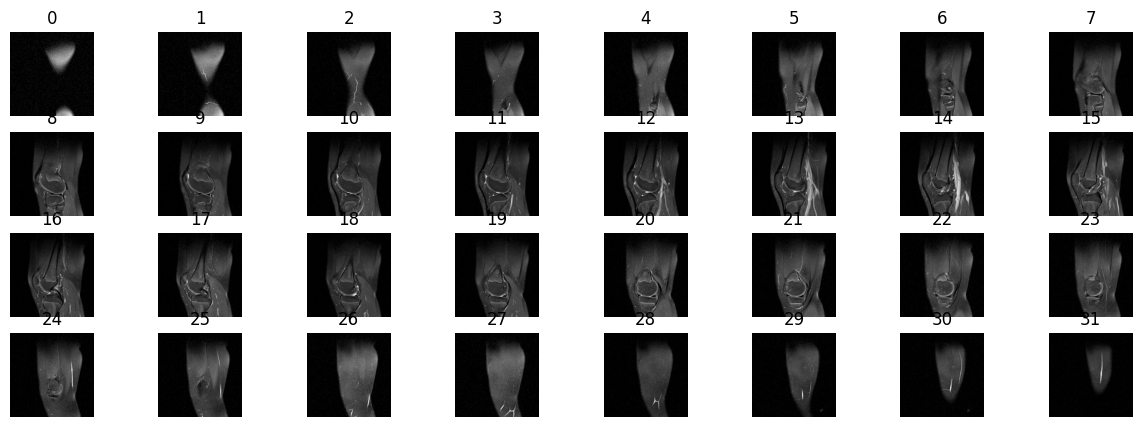

In [7]:
threshold = 80
mask = img > threshold
volume = img * mask

num_slices = volume.shape[0]
cols = 8
rows = num_slices // cols + (num_slices % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    if i < num_slices:
        ax.imshow(volume[i], cmap='gray')
        ax.set_title(f"{i}")
    ax.axis('off')
plt.tight_layout

In [8]:
def load_nifti_file(p: Path):
    img = nib.load(str(p))
    return img.get_fdata()

def load_image_auto(obj):
    if obj is None:
        return None
    if isinstance(obj, (np.ndarray, list, tuple)):
        return np.asarray(obj)
    p = Path(obj).expanduser()
    if not p.exists():
        raise FileNotFoundError(p)
    suffixes = "".join(p.suffixes).lower()
    if ".pck" in suffixes or ".pkl" in suffixes:
        return load_pickle_image(p)
    if ".nii" in suffixes or ".gz" in suffixes:
        return load_nifti_file(p)
    if p.suffix == ".npy":
        return np.load(str(p))
    try:
        return load_pickle_image(p)
    except Exception as e:
        raise RuntimeError(f"Nieznany format {p}: {e}") from e

def visualize_slices(volume, figsize=(9,3), cmap="gray"):
    vol = np.asarray(volume)
    if vol.ndim == 2:
        fig, ax = plt.subplots(1,1,figsize=(4,4))
        ax.imshow(vol, cmap=cmap); ax.set_title("2D")
    elif vol.ndim == 3:
        z,y,x = vol.shape
        cz, cy, cx = z//2, y//2, x//2
        fig, axes = plt.subplots(1,3,figsize=figsize)
        axes[0].imshow(vol[cz,:,:], cmap=cmap); axes[0].set_title("axial (Z)")
        axes[1].imshow(vol[:,cy,:], cmap=cmap); axes[1].set_title("coronal (Y)")
        axes[2].imshow(vol[:,:,cx], cmap=cmap); axes[2].set_title("sagittal (X)")
    else:
        raise ValueError("Oczekiwano 2D lub 3D array")
    plt.tight_layout()
    plt.show()
    return fig

def inspect_sample(sample):
    print("Keys:", list(sample.keys()))
    for k in ("prompt","answer","cot","final_diagnosis"):
        if k in sample:
            print(f"{k}: {sample[k]}")

In [9]:
split = 'train' if 'train' in ds.keys() else list(ds.keys())[0]
first_sample = ds[split][0]
print("First sample keys:", list(first_sample.keys()))
vol = inspect_sample(first_sample)


First sample keys: ['image', 'prompt', 'answer', 'cot', 'final_diagnosis']
Keys: ['image', 'prompt', 'answer', 'cot', 'final_diagnosis']
prompt: ### Question:
In this DESS MRI, can you diagnose bone-marrow lesions (BMLs) in the patella medial subregion? BMLs are scored using three MOAKS components: Size (Grade 0: None, Grade 1: <33% of subregion, Grade 2: 33-66% of subregion, Grade 3: >66% of subregion), Number (Grade 0: None, Grade 1: 1 BML, Grade 2: 2 BMLs, Grade 3: ≥3 BMLs), and % of lesion that is BML excluding cyst (Grade 0: None, Grade 1: <33%, Grade 2: 33-66%, Grade 3: >66%). Provide your reasoning, the bounding box of the patella medial subregion, and the MOAKS scores for size, number of BMLs, and percent of lesion that is BML. The output format should be a JSON object with the bounding box coordinates and the MOAKS scores: {"bounding_box": [start_slice, end_slice, x_min, x_max, y_min, y_max], "final_diagnosis": {"patella medial BML": {"Size of BML (including cyst)": (grade fro